In [27]:
import matplotlib.pyplot as pyplot
import numpy as np
from scipy.stats import pearsonr
import random
from operator import xor
import time

# Fast implementation of the Hamming weight for 64 bit values
# See book: A Hacker's delight
def popcount(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return ((x * 0x0101010101010101) & 0xffffffffffffffff ) >> 56

In [28]:
key = 0xe3cda8f459e1f0cf
plaintext = 0x624aa9b7b28eee6d

In [29]:

class Speck(object):
    valid_setups = {32: {64: 22},
                    48: {72: 22, 96: 23},
                    64: {96: 26, 128: 27},
                    96: {96: 28, 144: 29},
                    128: {128: 32, 192: 33, 256: 34}}
    
    
    def __init__(self, key, key_size=64, block_size=32):
        
        try:
            self.possible_setups = self.valid_setups[block_size]
            self.block_size = block_size
            self.word_size = self.block_size >> 1
            
        except KeyError:
            print("Invalid block size!")
            print("Please use one of the following block size: ", [x for x in self.valid_setups.keys()])
            raise
             
        try:
            self.rounds = self.possible_setups[key_size]
            self.key_size = key_size
        except KeyError:
            print("Invalid key size for selected block size!")
            print("Please use one of the following key sizes: ", [x for x in self.possible_setups.keys()])
            raise
        
        # Bit Maske für Shifts und Addition
        self.mod_mask = (2 ** self.word_size) - 1
        
        # Bis Maske für modulare Subtraktion
        self.mod_mask_sub = (2 ** self.word_size)
              
        # Setup Circular Shift Parameters - they depend on block size (if block size == 32 --> 2 & 7, else 3 & 8)
        if self.block_size == 32:
            self.beta_shift = 2
            self.alpha_shift = 7
        else:
            self.beta_shift = 3
            self.alpha_shift = 8

        # Parse the given key and truncate it to the key length
        try:
            self.key = key & ((2 ** self.key_size) - 1)
        except (ValueError, TypeError):
            print('Invalid Key Value!')
            print('Please Provide Key as int')
            raise

        # Pre-compile key schedule
 
        self.key_schedule = [self.key & self.mod_mask]
        l_schedule = [(self.key >> (x * self.word_size)) & self.mod_mask for x in
                      range(1, self.key_size // self.word_size)]
        
        for x in range(self.rounds - 1):
            new_l_k = self.encrypt_round(l_schedule[x], self.key_schedule[x], x)
            l_schedule.append(new_l_k[0])
            self.key_schedule.append(new_l_k[1])
        
    def encrypt_round(self, x, y, k):
        """Complete One Round of Feistel Operation"""
        
        rs_x = ((x << (self.word_size - self.alpha_shift)) + (x >> self.alpha_shift)) & self.mod_mask

        add_sxy = (rs_x + y) & self.mod_mask

        new_x = k ^ add_sxy
        
        
        ls_y = ((y >> (self.word_size - self.beta_shift)) + (y << self.beta_shift)) & self.mod_mask

        new_y = new_x ^ ls_y

        return new_x, new_y
    
    def encrypt(self, plaintext):
        try:
            b = (plaintext >> self.word_size) & self.mod_mask
            a = plaintext & self.mod_mask
        except TypeError:
            print('Invalid plaintext!')
            print('Please provide plaintext as int')
            raise

        b, a = self.encrypt_function(b, a)
            
        ciphertext = (b << self.word_size) + a

        return ciphertext
    
    def encrypt_function(self, upper_word, lower_word):    
        
        x = upper_word
        y = lower_word 

        # Run Encryption Steps For Appropriate Number of Rounds
        for k in self.key_schedule:
            
            rs_x = ((x << (self.word_size - self.alpha_shift)) + (x >> self.alpha_shift)) & self.mod_mask

            add_sxy = (rs_x + y) & self.mod_mask

            x = k ^ add_sxy

            ls_y = ((y >> (self.word_size - self.beta_shift)) + (y << self.beta_shift)) & self.mod_mask

            y = x ^ ls_y
            
        return x,y   

if __name__ == "__main__":
    cipher = Speck(0x55, 128, 64)
    g = cipher.encrypt(plaintext)
    print(hex(g))

0xe34d84ecf40020e6


In [5]:
print(key)

16414961984268792015


In [25]:
import random 
help(random)

Help on module random:

NAME
    random - Random variable generators.

MODULE REFERENCE
    https://docs.python.org/3.7/library/random
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
        integers
        --------
               uniform within range
    
        sequences
        ---------
               pick random element
               pick random sample
               pick weighted random sample
               generate random permutation
    
        distributions on the real line:
        ------------------------------
               uniform
               triangular
               normal (Gaussian)
               lognormal
               negative exponential
               gamma
             

In [33]:
print(hex(random.getrandbits(64)))

0x624aa9b7b28eee6d


In [75]:
def simplified_speck (plaintext):
    k = 0x1110
    x = plaintext
    y = 0x110
    alpha_shift = 8
    beta_shift = 3
    word_size = 64 >> 1
    mod_mask = (2 ** word_size) - 1
    
    rs_x = ((x << (word_size - alpha_shift)) + (x >> alpha_shift)) & mod_mask
    
    add_sxy = (rs_x + y) & mod_mask

    new_x = k ^ x

    #ls_y = ((y >> (word_size - beta_shift)) + (y << beta_shift)) & mod_mask

    #new_y = new_x ^ ls_y

    return add_sxy


In [50]:
block_size = 64
word_size = block_size >> 1
key_size = 128
key = 0x00000000000055
alpha_shift = 8
beta_shift = 3
mod_mask = (2 ** word_size) - 1

def simpleSpeck(plaintext):    
    right_key = key & mod_mask 
    right_plain = plaintext & mod_mask
    left_plain = (plaintext >> word_size) & mod_mask

    rs_x = ((left_plain << (word_size - alpha_shift)) + (right_plain >> alpha_shift)) & mod_mask

    add_sxy = (rs_x + right_plain) & mod_mask

    x = right_key ^ add_sxy
    
    return x

def hw_model(key_guess, plaintext):    
    right_key = key_guess & mod_mask 
    right_plain = plaintext & mod_mask
    left_plain = (plaintext >> word_size) & mod_mask
    
    rs_x = ((left_plain << (word_size - alpha_shift)) + (right_plain >> alpha_shift)) & mod_mask
    
    add_sxy = (rs_x + right_plain) & mod_mask

    x = key_guess ^ add_sxy
    
    return x



In [51]:
simpleSpeck(plaintext)

2595877967

In [52]:
plaintext = 0x5248718298

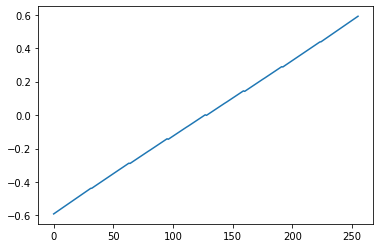

Correct 8-bit key is: 0xff


In [53]:
num_traces = 1000

traces = np.empty(num_traces)
hw_traces = np.empty((256, num_traces))

for i in range(0,num_traces):
    traces[i] = popcount(simpleSpeck(i%256)) 
    for key in range(0, 256):
        hw_traces[key][i] = hw_model(key, i%256)
        
corr = np.empty(256)
        
#compute pearson correlation for each key
for key in range(0, 256):
    corr[key],p = pearsonr(hw_traces[key], traces)

pyplot.plot(corr)
pyplot.show()

print("Correct 8-bit key is: " + hex(np.argmax(corr)))